In [32]:
import pandas as pd
import numpy as np

In [118]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [119]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, plot_mpl
init_notebook_mode(connected=True)

In [63]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

def clean_plot(leg=True, grid=None, font=None):
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    axis_color = 'lightgrey'
    ax.spines['bottom'].set_color(axis_color)
    ax.spines['left'].set_color(axis_color)
    ax.tick_params(axis='both', color=axis_color)
    
    if leg:
        ax.legend(frameon = False, loc='upper left', bbox_to_anchor=(1, 1))
        
    if grid is not None:
        plt.grid(color='lightgrey', axis = grid, linestyle='-', linewidth=.5)
        
    if font is not None:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
            ax.get_xticklabels() + ax.get_yticklabels()):
            
            item.set_fontfamily(font['family'])
            item.set_color(font['color'])

In [3]:
fp = '../DS5500_HW3/'

In [4]:
data = pd.read_csv(f'{fp}Sdf16_1a.txt', sep='\t')

C:\software\Anaconda3\envs\advanced\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (0,3) have mixed types. Specify dtype option on import or set low_memory=False.



# Problem 1

In [39]:
data['New Funding'] = data['TFEDREV'] * .85
data['cut'] = data['TFEDREV'] - data['New Funding']

data[['LEAID','STNAME','TFEDREV','New Funding', 'cut']].sort_values('cut', ascending=False).reset_index(drop=True).head(10)


,LEAID,STNAME,TFEDREV,New Funding,cut
0,3620580,New York,1739101000,1.478236e+09,260865150.0
1,622710,California,1091400000,9.276900e+08,163710000.0
2,1709930,Illinois,792420000,6.735570e+08,118863000.0
3,1200390,Florida,431519000,3.667912e+08,64727850.0
4,1200870,Florida,308427000,2.621630e+08,46264050.0
5,4823640,Texas,293958000,2.498643e+08,44093700.0
6,4816230,Texas,287161000,2.440868e+08,43074150.0
7,1200180,Florida,278292000,2.365482e+08,41743800.0
8,3200060,Nevada,277628000,2.359838e+08,41644200.0
9,4218990,Pennsylvania,271369000,2.306636e+08,40705350.0


In [120]:
v = data[['LEAID','STNAME','TFEDREV','New Funding', 'cut']].sort_values('cut', ascending=False).reset_index(drop=True).head(10)
v['LEAID'] = v['LEAID'].apply(lambda x: 'LEAID: ' + str(x))


fig = px.bar(v.sort_values('cut'), x='cut', y='LEAID', orientation='h', hover_data=['STNAME'])

fig.layout.title.text = '10 Largest Budget Cuts'
fig.layout.xaxis.title = 'Budget Cuts (USD)'
fig.layout.yaxis.title = ''

fig.show()

# Problem 2

In [38]:
demog = pd.read_csv(f'{fp}ccd_lea_052_1516_w_1a_011717.csv', sep=',')

demog['am_dist'] = demog['AM'] / demog['TOTAL']
demog['as_dist'] = demog['AS'] / demog['TOTAL']
demog['hi_dist'] = demog['HI'] / demog['TOTAL']
demog['bl_dist'] = demog['BL'] / demog['TOTAL']
demog['wh_dist'] = demog['WH'] / demog['TOTAL']
demog['hp_dist'] = demog['HP'] / demog['TOTAL']
demog['tr_dist'] = demog['TR'] / demog['TOTAL']

In [55]:
viz = data[['LEAID', 'cut']].merge(demog[['LEAID', 'am_dist', 'as_dist', 'hi_dist', 'bl_dist', 'wh_dist', 'hp_dist', 'tr_dist']],
                                  how='left', on='LEAID')

viz=viz[viz.cut > 10]

dists = ['am_dist', 'as_dist', 'hi_dist', 'bl_dist', 'wh_dist', 'hp_dist', 'tr_dist']
for d in dists:
    viz[d] = viz[d] * viz['cut']


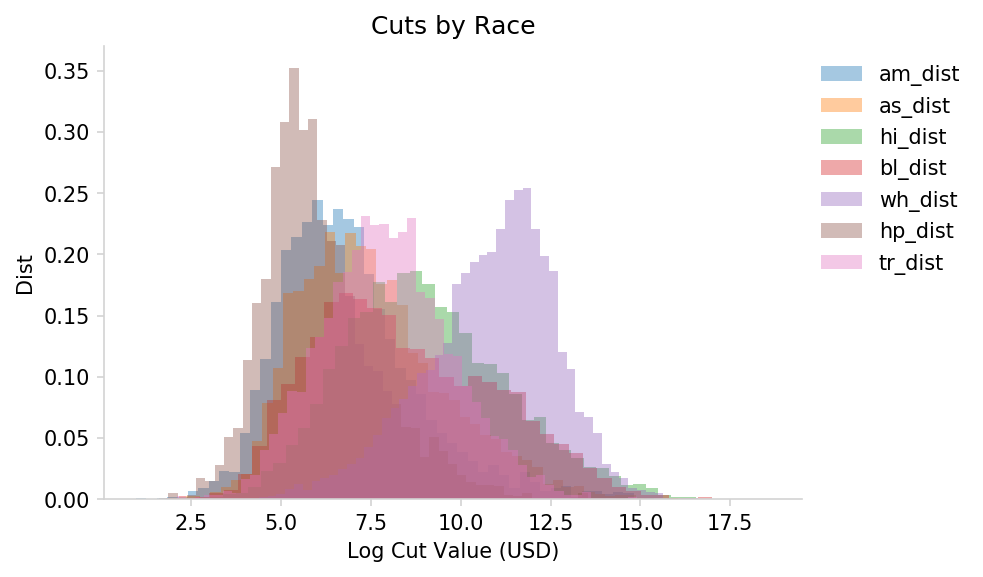

In [78]:
_, ax = plt.subplots()

for d in dists:
    sns.distplot(viz[viz[d] > 0][d].dropna().apply(np.log), kde=False,norm_hist=True, label=d, ax=ax)
    
ax.set_xlabel('Log Cut Value (USD)')
ax.set_ylabel('Dist')
ax.set_title('Cuts by Race')
    
clean_plot()

I focused on the real value of cuts by race, where the real value of cuts are the budget cut of a district multiplied by the proportion of a given race in the district. This reflects the general distribution of funding, as a uniform percentage cut emulates the underlying distribution. We can see that the race 'WH' clearly recieved the largest dollar impact from all races. The race 'HI' recieved the small dollar impact, as they started with a lower funding amount. The hidden biases from my selection are the same general biases in funding, being that the race 'WH' generally recieves more funding. Therefore, it also recieves more cuts.

# Problem 3

In [79]:
disab = pd.read_csv(f'{fp}ccd_lea_002089_1516_w_1a_011717.csv', sep=',')

In [113]:
viz = data[['LEAID', 'cut']].merge(demog[['LEAID', 'TOTAL']], how='left', on='LEAID') \
    .merge(disab[['LEAID', 'SPECED']], how='left', on='LEAID')

viz = viz[viz.cut > 10]
viz = viz[viz.TOTAL > 0]

viz['prop_disab'] = viz['SPECED'] / viz['TOTAL']
viz['prop_not_disab'] = 1 - viz['prop_disab']

viz['prop_disab_w'] = viz['prop_disab'] * viz['cut']
viz['prop_not_disab_w'] = viz['prop_not_disab'] * viz['cut']

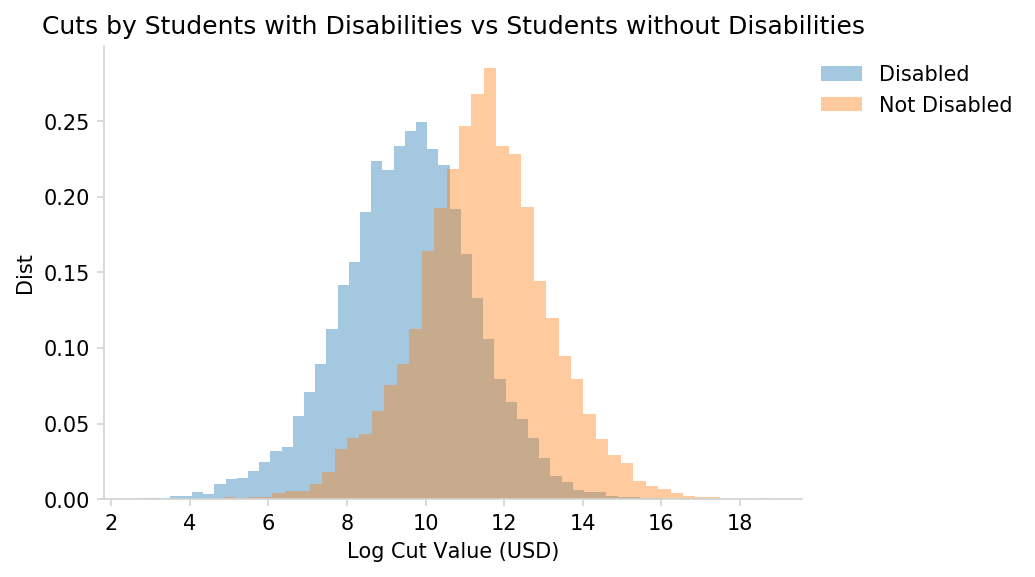

In [117]:
_, ax = plt.subplots()

sns.distplot(viz[viz['prop_disab'] > 0]['prop_disab_w'].dropna().apply(np.log), kde=False,norm_hist=True, label='Disabled', ax=ax)
sns.distplot(viz[viz['prop_not_disab'] > 0]['prop_not_disab_w'].dropna().apply(np.log), kde=False,norm_hist=True, label='Not Disabled', ax=ax)

ax.set_xlabel('Log Cut Value (USD)')
ax.set_ylabel('Dist')
ax.set_title('Cuts by Students with Disabilities vs Students without Disabilities')

clean_plot()

Again, since all districts recieved budget cuts, I vizualized the weighted real dollar amount for budget cuts. The budget cuts retained the biases from the funding distribution. Hence, students with disabilities tended to recieve a smaller amount from the origional budget, and therefore recieve a smaller cut. This analysis does not account for confounding variables. For instance, it may be the case that certain regions have a higher number of students with disabilities, and the funding cuts are more strongly correlated to the region.

# Problem 4

I reviewed Omair's solutions at:
https://github.com/Omairss/ds5500-hw3

Overall, I really like the apporach by Omair. The cascading budget cuts, alloting only 20% to the most funded districts, makes a lot of sense to preserve the budgets of less funded districts. Taking a smaller amount from a district with a large budget could amount to size of an entire district that recieves less funding, hopefully impacting the smaller district less. However, I'm not sure I agree with the notion that schools with lower budgets are the ones already struggling. The landscape of funding for schools in the United States is more complex, and the least funding schools might not be the ones that struggle most. For instance, I know on occasion schools have struggled due to poverty in the district, and more funding can be alotted to the district to help. Additionally, good schools in rural regions could have lower budgets than struggling schools in urban regions because of the different costs of living.

# Problem 5

My biggest takeaway from a guest lecturer this semester came during the Map Raduce lecture. I have not taken any courses in distributed processing, and none of the other lectures I attended mentioned the drawbacks of map reduce algorithms. The lecture did a good job of ingraining the idea of only using map reduce algorithms when something can't be fit into memory, which I considered my biggest takeaway that I did not know before the semeseter. I also enjoyed hearing the anecdotal stories about the origin of the algorithm.